### Variational Autoencoder. 

In [24]:
import os

import numpy as np
import torch
import torch.nn.functional as F
import torchvision as tv

import matplotlib.pyplot as plt

%matplotlib inline
%config InlineBackend.figure_format = 'retina'


### Load MNIST dataset.

In [13]:
#transform = tv.transforms.Compose([tv.transforms.ToTensor()])
transform = tv.transforms.Compose([tv.transforms.ToTensor(),
                                tv.transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

datasets = {
    'train': tv.datasets.MNIST(os.path.join('mnist', 'train'), 
                               train=True, 
                               download=True, 
                               transform=transform),
    'test': tv.datasets.MNIST(os.path.join('mnist', 'test'), 
                              train=False, 
                              download=True, 
                              transform=transform),    
}

dataloaders = {
    name: torch.utils.data.DataLoader(value, batch_size=64, shuffle=True) for name, value in datasets.items()
}    


In [18]:
def imshow(image, ax=None, title=None, normalize=True):
    """Imshow for Tensor."""
    if ax is None:
        fig, ax = plt.subplots()
    image = image.numpy().transpose((1, 2, 0))

    if normalize:
        mean = np.array([0.5, .5, 0.5])
        std = np.array([0.5, 0.5, 0.5])
        image = std * image + mean
        image = np.clip(image, 0, 1)

    ax.imshow(image)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.tick_params(axis='both', length=0)
    ax.set_xticklabels('')
    ax.set_yticklabels('')

    return ax

torch.Size([64, 1, 28, 28])

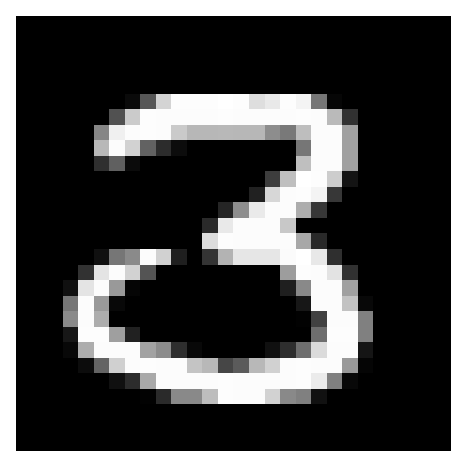

In [19]:
image, label = next(iter(dataloaders['train']))
imshow(image[0])
image.shape

#### Define model for training Variational Auto Encoder.

In [51]:
class Model(torch.nn.Module):
    def __init__(self, input_size, code_size, hidden_size):
        super(Model, self).__init__()
        self.code_size = code_size
        self.input_size = input_size
        self.encoder_fc1 = torch.nn.Linear(input_size, hidden_size)
        self.encoder_fc2 = torch.nn.Linear(hidden_size, code_size*2)
        self.decoder_fc1 = torch.nn.Linear(code_size, hidden_size)
        self.decoder_fc2 = torch.nn.Linear(hidden_size, input_size*2)
        self.z = torch.nn.Parameter(torch.Tensor(code_size), requires_grad=True)

    def forward(self, x):
        x = F.relu(self.encoder_fc1(x))
        x = F.relu(self.encoder_fc2(x))
        e = torch.normal(torch.zeros(self.code_size), torch.ones(self.code_size))
        mu = x[:, :self.code_size]
        sigma = torch.sqrt(torch.exp(x[:, self.code_size: ]))
#        print("shape: {} e: {} sigma: {}".format(x.shape, e, sigma))
        self.z = torch.nn.Parameter(mu + e*sigma) #x[:self.code_size] + e * torch.sqrt(torch.exp(x[self.code_size: ]))
        x = F.relu(self.decoder_fc1(self.z))
        x = F.relu(self.decoder_fc2(x))
        e = torch.normal(torch.zeros(self.input_size), torch.ones(self.input_size))
        return x[:, :self.input_size] + e * x[:, self.input_size: ] 
                                  
        

Shape: torch.Size([64, 1, 28, 28])
z shape: torch.Size([64, 2])
y_hat: torch.Size([64, 784])


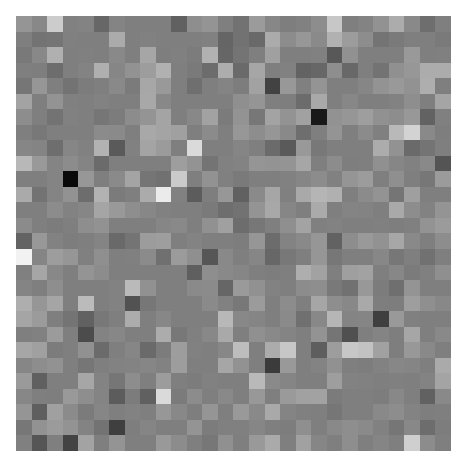

In [60]:
N = 28*28
model = Model(N, 2, 500)
for x, y in iter(dataloaders['train']):
    model.train()
    print("Shape: {}".format(x.shape))
    x.resize_(x.shape[0], N)
#    x, y = x.to(device), y.to(device)
    y_hat = model(x)
    print ("y_hat: {}".format(y_hat.shape))
    im= y_hat.detach().numpy()
    im.resize(x.shape[0], 1, 28, 28)
    imshow(torch.Tensor(im[0]))
    break
